In [2]:
import os
import zipfile

# Ensure Kaggle API credentials are in place
os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
with open(os.path.expanduser('~/.kaggle/kaggle.json'), 'w') as f:
    f.write('{"username":"YOUR_USERNAME","key":"YOUR_KEY"}')

# Download the dataset from Kaggle
!kaggle datasets download -d emmarex/plantdisease

# Unzip the downloaded dataset
with zipfile.ZipFile('plantdisease.zip', 'r') as zip_ref:
    zip_ref.extractall('PlantVillage')

# Remove the zip file
os.remove('plantdisease.zip')


Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
100% 655M/658M [00:37<00:00, 19.8MB/s]
100% 658M/658M [00:38<00:00, 18.1MB/s]


In [3]:
!pip install tensorflow numpy pandas opencv-python scikit-learn

In [4]:
pip install numpy opencv-python scikit-learn pywavelets scikit-image


In [5]:
import cv2
import numpy as np
import pywt
from sklearn.decomposition import PCA
from skimage.feature import greycomatrix, greycoprops

# Step 1: Histogram Equalization
def histogram_equalization(image):
    if len(image.shape) == 3:
        img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
        image = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    else:
        image = cv2.equalizeHist(image)
    return image

# Step 2: K-means Clustering
def kmeans_clustering(image, k=3):
    pixel_values = image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)
    _, labels, centers = cv2.kmeans(pixel_values, k, None,
                                    (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2),
                                    10, cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image.shape)
    return segmented_image

# Step 3: Contour Tracing
def contour_tracing(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blurred, 50, 150)
    contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

# Step 4: Discrete Wavelet Transform (DWT)
def dwt(image):
    coeffs2 = pywt.dwt2(image, 'bior1.3')
    LL, (LH, HL, HH) = coeffs2
    return LL, LH, HL, HH

# Step 5: Principal Component Analysis (PCA)
def apply_pca(data, n_components=50):
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(data)
    return principal_components

# Step 6: Gray-Level Co-occurrence Matrix (GLCM)
def glcm_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    glcm = greycomatrix(gray, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], symmetric=True, normed=True)
    contrast = greycoprops(glcm, 'contrast')
    dissimilarity = greycoprops(glcm, 'dissimilarity')
    homogeneity = greycoprops(glcm, 'homogeneity')
    energy = greycoprops(glcm, 'energy')
    correlation = greycoprops(glcm, 'correlation')
    return contrast, dissimilarity, homogeneity, energy, correlation

# Apply preprocessing to dataset
import os
from glob import glob

dataset_path = '/content/PlantVillage'
image_files = glob(os.path.join(dataset_path, '*.jpg'))

preprocessed_data = []

for file in image_files:
    image = cv2.imread(file)
    # Step 1: Histogram Equalization
    image = histogram_equalization(image)
    # Step 2: K-means Clustering
    image = kmeans_clustering(image)
    # Step 3: Contour Tracing
    contours = contour_tracing(image)
    # Step 4: Discrete Wavelet Transform (DWT)
    LL, LH, HL, HH = dwt(image)
    # Step 5: Principal Component Analysis (PCA)
    image_reshaped = LL.reshape(-1, LL.shape[2])
    pca_features = apply_pca(image_reshaped)
    # Step 6: Gray-Level Co-occurrence Matrix (GLCM)
    contrast, dissimilarity, homogeneity, energy, correlation = glcm_features(image)

    # Collecting all features
    features = np.hstack((pca_features.flatten(), contrast.flatten(), dissimilarity.flatten(),
                          homogeneity.flatten(), energy.flatten(), correlation.flatten()))

    preprocessed_data.append(features)

# Convert to numpy array
preprocessed_data = np.array(preprocessed_data)


In [6]:
!pip install tensorflow_model_optimization
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_model_optimization as tfmot
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_fscore_support
import os
import time

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 2.4 MB/s eta 0:00:00


In [7]:
# Define all hyperparameters
BATCH_SIZE = 32
IMAGE_SIZE = 128
CHANNELS = 3
EPOCHS = 500
CLASS_NAMES = [
    'Pepper__bell___Bacterial_spot',
    'Pepper__bell___healthy',
    'Potato___Early_blight',
    'Potato___Late_blight',
    'Potato___healthy',
    'Tomato_Bacterial_spot',
    'Tomato_Early_blight',
    'Tomato_Late_blight',
    'Tomato_Leaf_Mold',
    'Tomato_Septoria_leaf_spot',
    'Tomato_Spider_mites_Two_spotted_spider_mite',
    'Tomato__Target_Spot',
    'Tomato__Tomato_YellowLeaf__Curl_Virus',
    'Tomato__Tomato_mosaic_virus',
    'Tomato_healthy',
]

In [8]:
# Load dataset
dataset_dir = "/content/PlantVillage/PlantVillage"

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    labels='inferred',
    label_mode='int',
    class_names=CLASS_NAMES,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training"
)
dataset_val = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    labels='inferred',
    label_mode='int',
    class_names=CLASS_NAMES,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation"
)

Found 20638 files belonging to 15 classes.
Using 16511 files for training.
Found 20638 files belonging to 15 classes.
Using 4127 files for validation.


In [9]:
# Cache, shuffle, and prefetch the dataset
train_ds = dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = dataset_val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
# Define data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),  # Changed here
    layers.RandomRotation(0.2),                    # Changed here
])

In [11]:
# Define model architecture
model = models.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),       # Changed here
    layers.Rescaling(1./255),                      # Changed here
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(CLASS_NAMES), activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [12]:
# Measure training time
start_time = time.time()

In [13]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")

Epoch 1/500
516/516 [==============================] - 27s 24ms/step - loss: 1.4272 - accuracy: 0.5445 - val_loss: 0.9646 - val_accuracy: 0.6835
Epoch 2/500
516/516 [==============================] - 8s 16ms/step - loss: 0.7789 - accuracy: 0.7403 - val_loss: 0.9734 - val_accuracy: 0.6775
Epoch 3/500
516/516 [==============================] - 8s 16ms/step - loss: 0.6301 - accuracy: 0.7864 - val_loss: 0.6558 - val_accuracy: 0.7727
Epoch 4/500
516/516 [==============================] - 9s 17ms/step - loss: 0.5369 - accuracy: 0.8205 - val_loss: 0.5050 - val_accuracy: 0.8425
Epoch 5/500
516/516 [==============================] - 9s 17ms/step - loss: 0.4800 - accuracy: 0.8390 - val_loss: 0.4730 - val_accuracy: 0.8457
Epoch 6/500
516/516 [==============================] - 9s 17ms/step - loss: 0.4449 - accuracy: 0.8508 - val_loss: 0.4297 - val_accuracy: 0.8670
Epoch 7/500
516/516 [==============================] - 9s 17ms/step - loss: 0.4137 - accuracy: 0.8581 - val_loss: 0.5472 - val_accuracy

In [14]:
# Evaluate the model
test_ds = dataset_val
scores = model.evaluate(test_ds)

129/129 [==============================] - 3s 22ms/step - loss: 0.6700 - accuracy: 0.9443


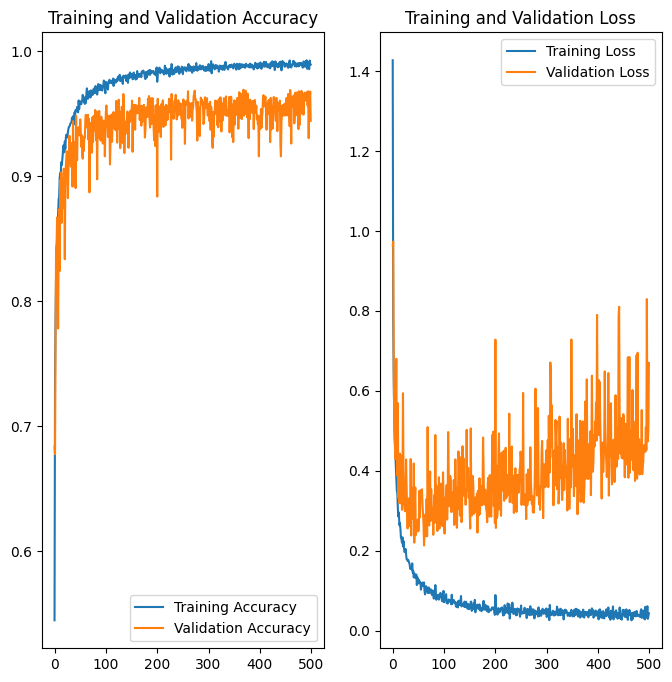

In [15]:
# Plot accuracy and loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
# Example saving model weights in Colab
model.save_weights('/content/model_weights.h5')


1/1 [==============================] - 0s 84ms/step
Confusion Matrix:
[[172   3   0   0   0   0   0   0   0   1   0   0   0   0   0]
 [  1 278   0   0   1   0   0   0   0   0   0   0   0   0   0]
 [  3   0 188   0   0   0   2   0   0   0   0   0   0   0   1]
 [  0   0   1 209   8   0   3   0   0   1   0   1   0   0   1]
 [  0   2   0   0  27   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   2   0 382   8   6   2   1   0   9   3   0   1]
 [  3   4   2   3   0   1 170   8   0   4   3   2   0   0   0]
 [  1   9   1   1   1   1   9 338   0   2   3   0   1   0   2]
 [  1   2   0   0   0   0   3   0 192   8   0   0   0   2   0]
 [ 14   3   3   1   0   0   6   1   0 303   1   0   1   4   0]
 [  0   0   0   0   2   0   3   2   0   0 298   3   3   5   4]
 [  0   0   0   0   2   0   1   0   2   0  17 259   0   0   3]
 [  1   1   0   0   0   5   0   1   0   0   1   0 671   0   0]
 [  0   0   0   0   0   0   1   0   0   0   0   0   0  73   0]
 [  0   0   0   0   0   0   0   1   0   0   0   

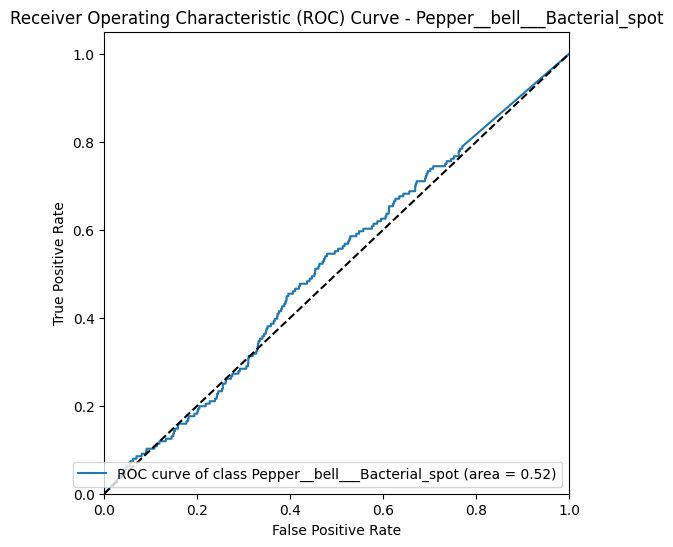

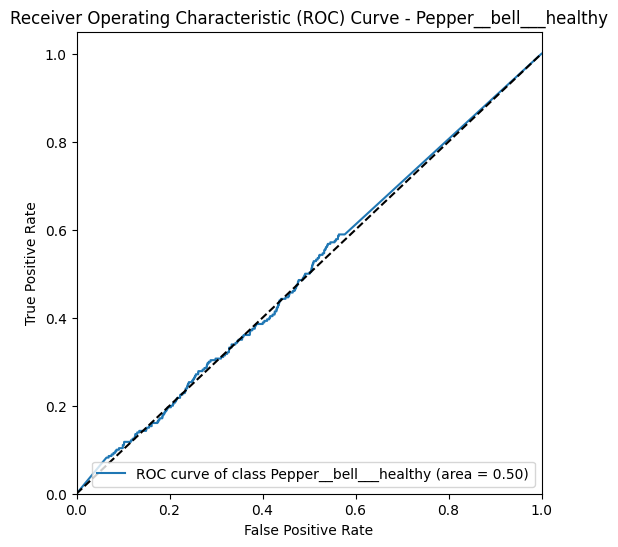

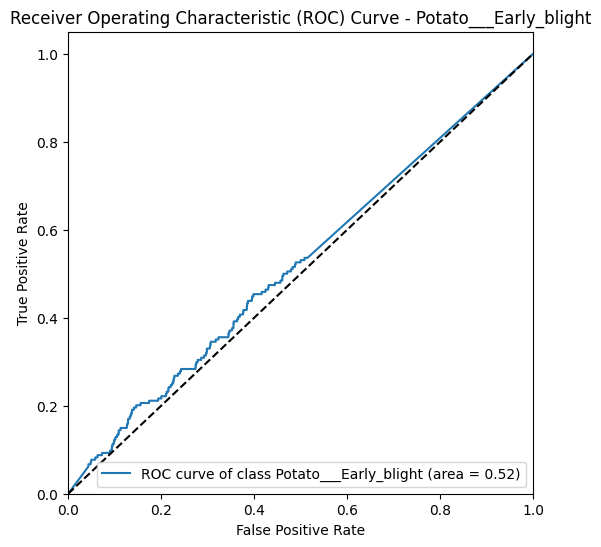

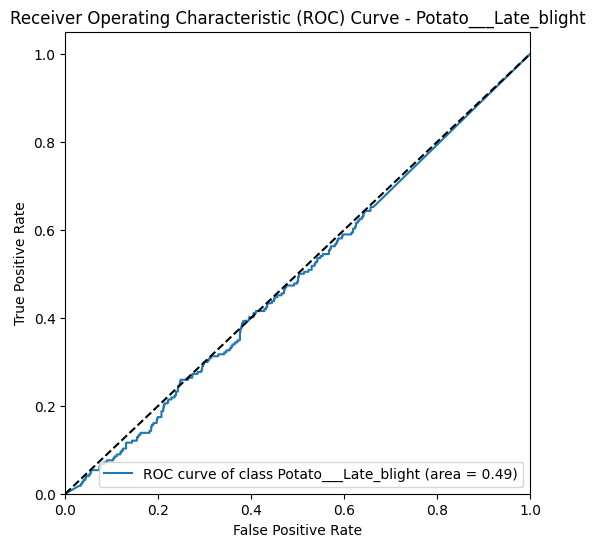

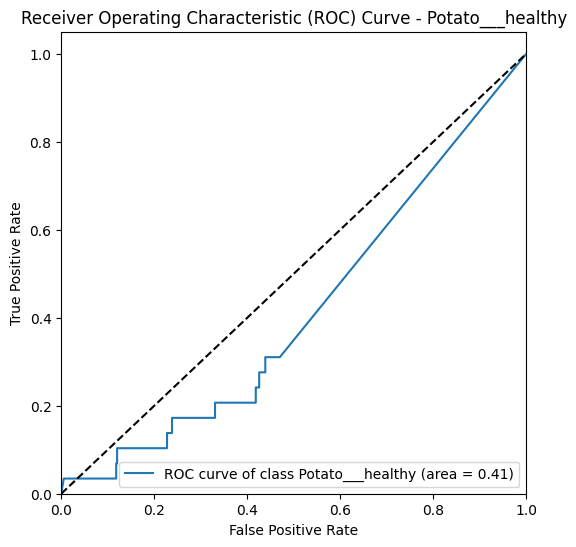

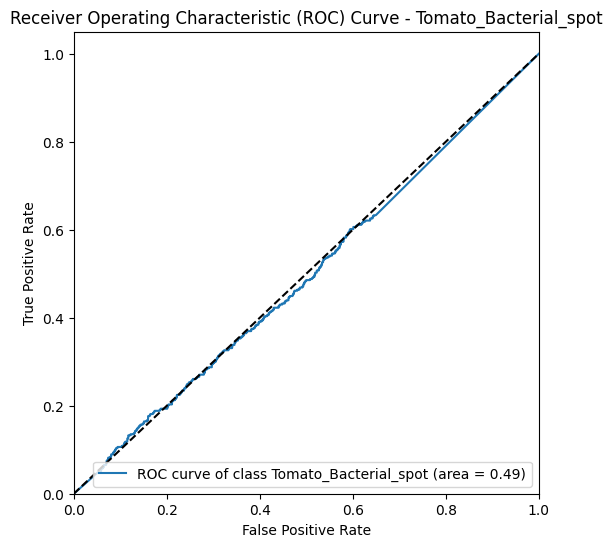

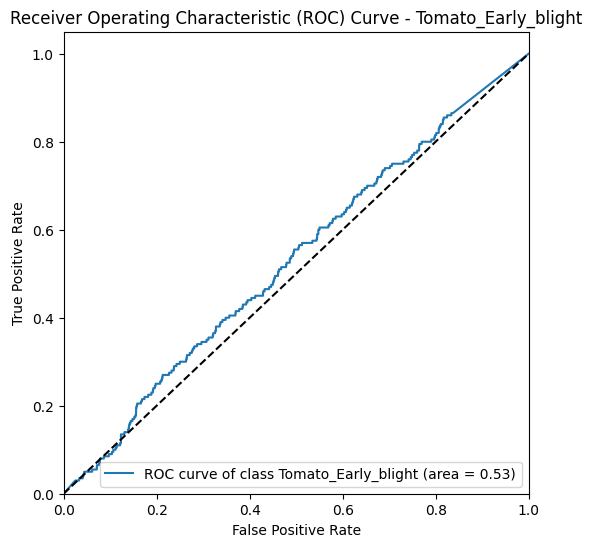

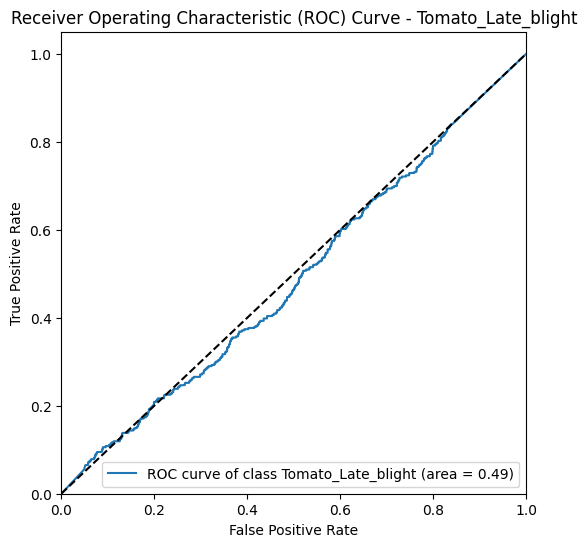

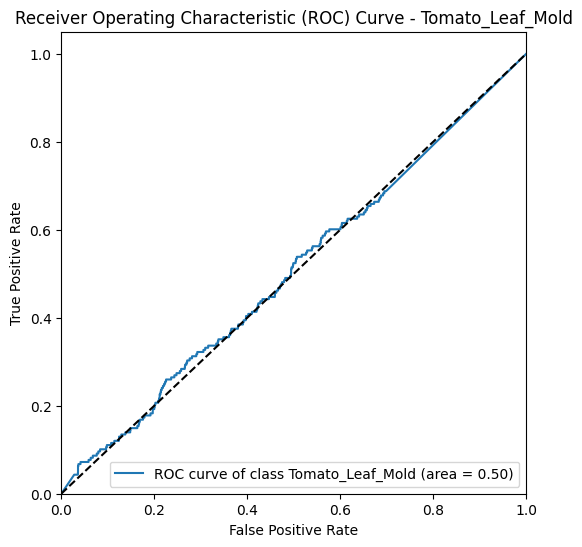

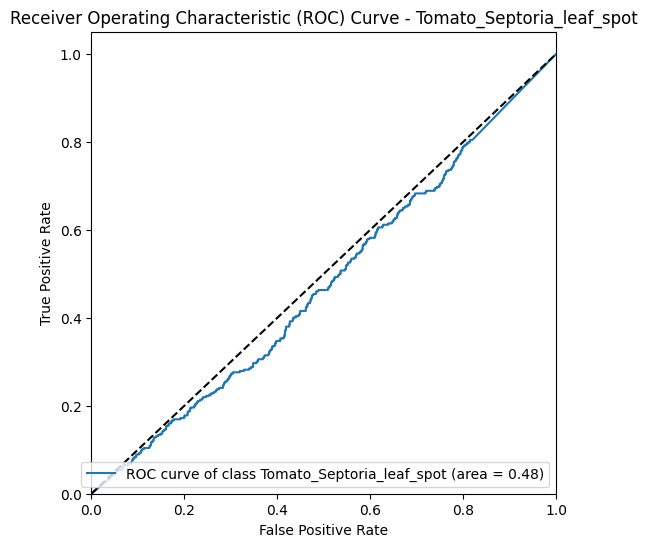

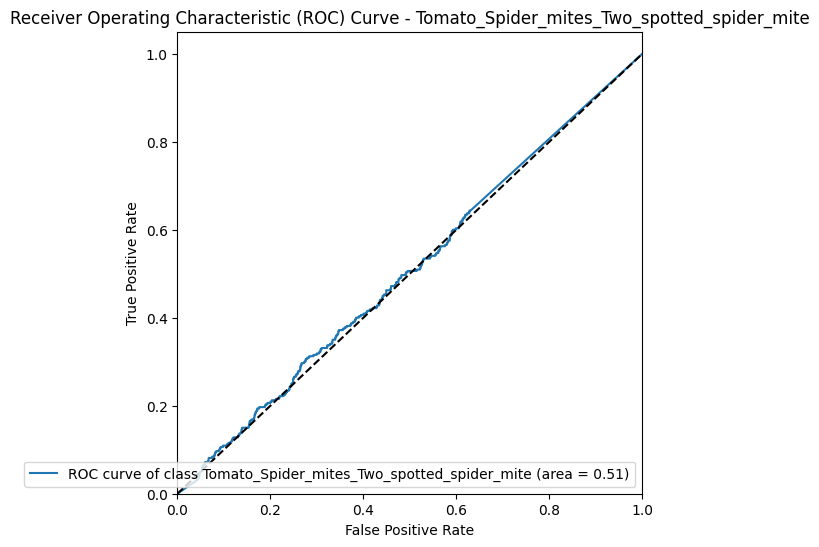

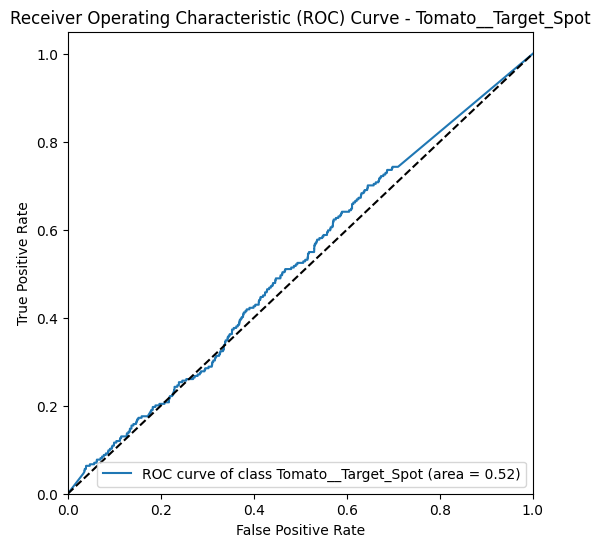

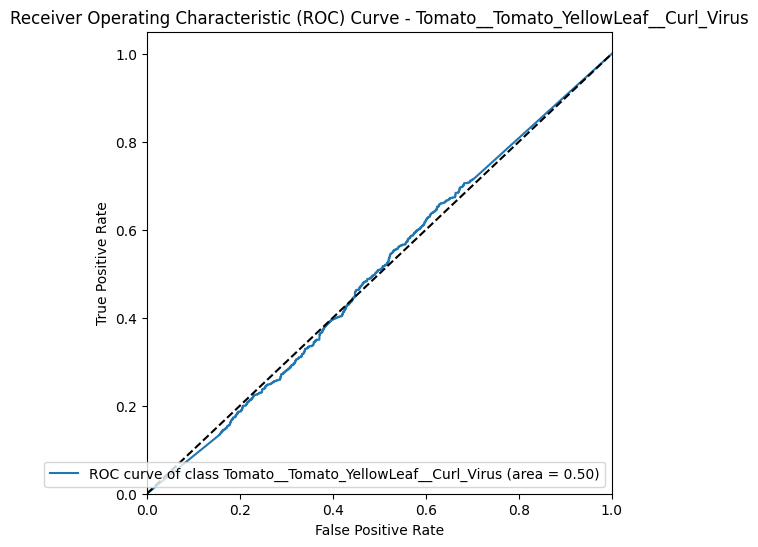

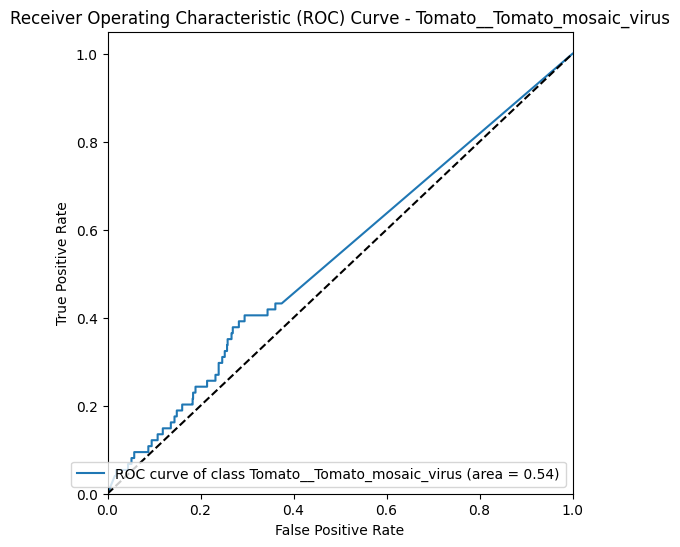

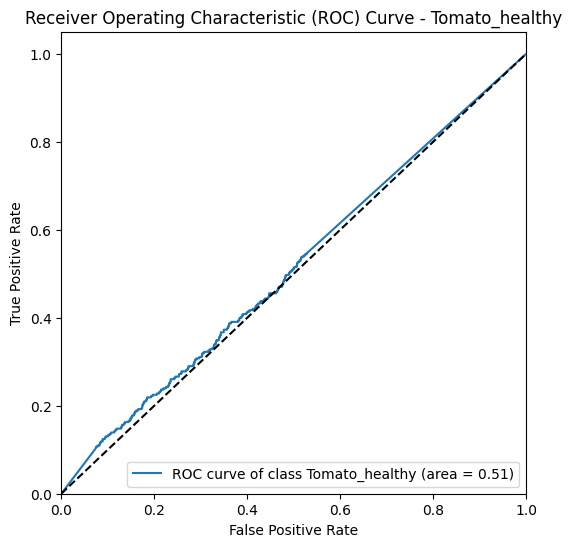

In [17]:
# Additional Metrics
# Get predictions and labels
y_pred = []
y_true = []
for images, labels in test_ds:
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Precision, Recall, F1 Score
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# ROC Curve and AUC
y_pred_prob = model.predict(test_ds)
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(CLASS_NAMES)):
    fpr[i], tpr[i], _ = roc_curve(np.array(y_true) == i, y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot individual ROC curves
for i in range(len(CLASS_NAMES)):
    plt.figure(figsize=(6, 6))
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {CLASS_NAMES[i]} (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve - {CLASS_NAMES[i]}')
    plt.legend(loc='lower right')
    plt.show()
